# Lesson 4: Adsorption models

At the core of chromatographic processes are interactions between the atoms, ions or molecules of a gas, liquid or dissolved solid with a stationary phase.
These interactions can often be described in terms of an isotherm which relates the amount of adsorbate on the adsorbent as a function of its pressure (in gas phase) or concentration (in solution) at constant temperature.

In CADET, many different models for adsorption are implemented.
All of the models can be modelled kinetically or in rapid equilibrium. 
Moreover, many of them include features such as competitive effects, multi state binding, or a mobile phase modifier.

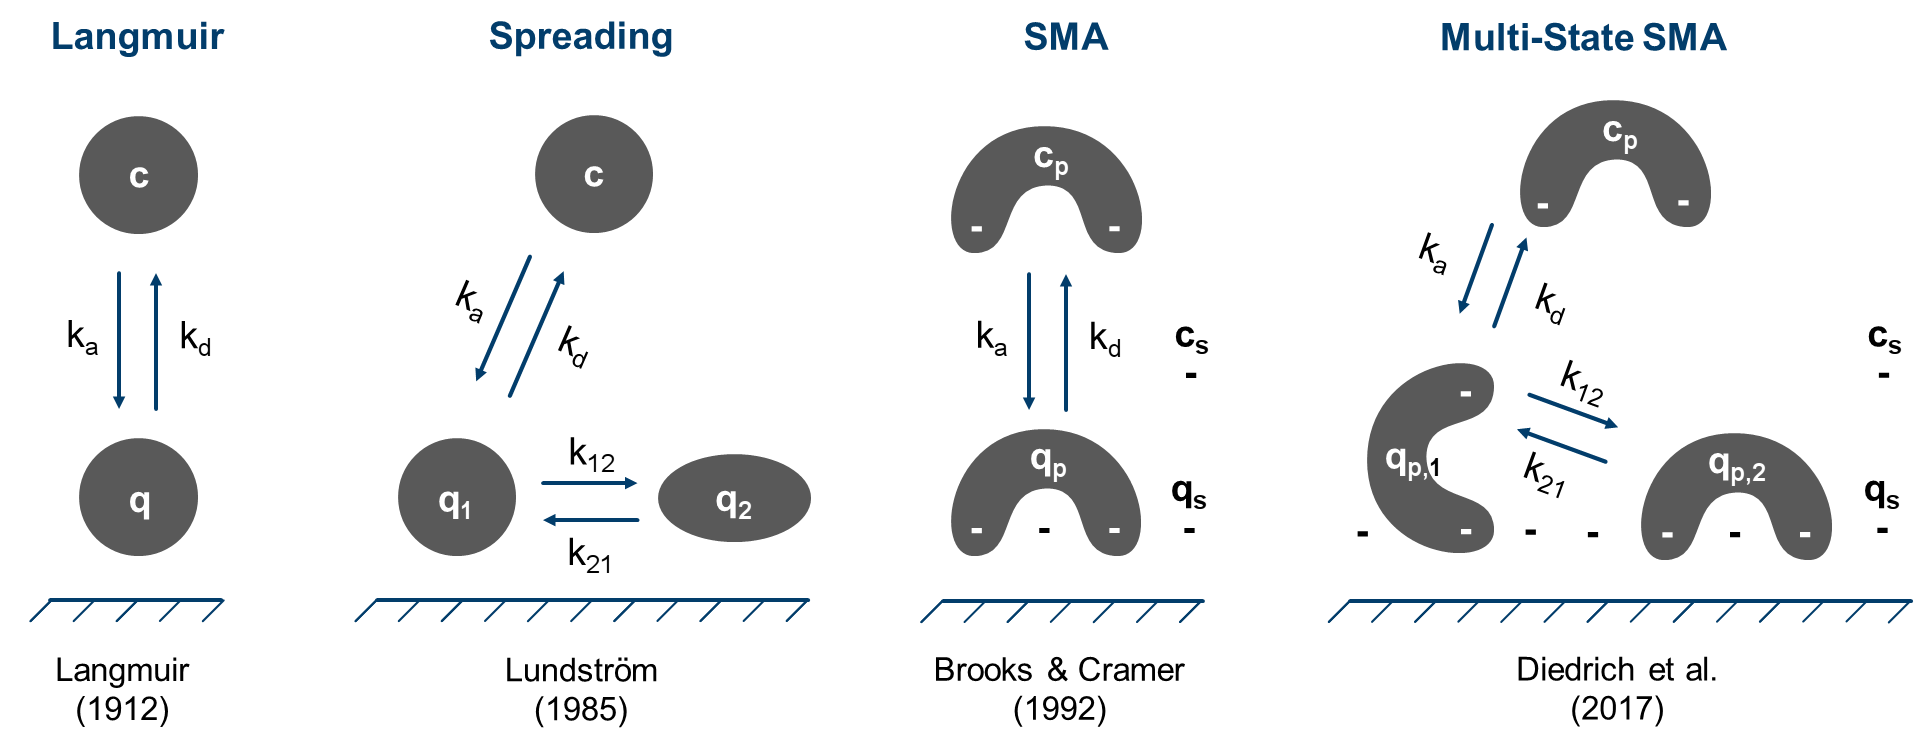
 
**In this lesson,** we will:
- Learn about different adsorption models.
- Associate adsorption models with different unit operations.

## Load CADETSettings

This imports all the standard libraries and provides some helper functions.

In [1]:
%run ../utils.ipynb

## Example 1: Linear model

The simplest model for adsorption is the [linear model](https://cadet.github.io/master/modelling/binding/linear.html).
Analogously to Henry's law, it describes a linear correlation of the amount of the surface adsorbate to the partial pressure of the adsorptive gas or the concentration of the solute.


Let us consider a shaking flask experiment a `CSTR` (without ingoing or outgoing streams).
In it, we add some porous material s.t. the overal porosity is $0.5$. 
Then, we a solution of a component with $1~mol \cdot L^{-1}$. 


Before defining the adsorption paramters, we start by defining the system of unit operations.

In [2]:
linear_model = get_cadet_template(n_units=1)

# CSTR
linear_model.root.input.model.unit_000.unit_type = 'CSTR'
linear_model.root.input.model.unit_000.ncomp = 1
linear_model.root.input.model.unit_000.init_volume = 1e-3
linear_model.root.input.model.unit_000.porosity = 0.5
linear_model.root.input.model.unit_000.init_c = [1]
linear_model.root.input.model.unit_000.init_q = [0]

# Sections and Switches
linear_model.root.input.solver.sections.nsec = 1
linear_model.root.input.solver.sections.section_times = [0.0, 10]
linear_model.root.input.solver.user_solution_times = np.linspace(0, 10, 1001)

linear_model.root.input.model.connections.nswitches = 1
linear_model.root.input.model.connections.switch_000.section = 0
linear_model.root.input.model.connections.switch_000.connections = []

Then we define the adsorption model by setting the `adsorption_model` parameter in the corresponding unit operation and defining the required parameters.
Moreover, we have to specify the number of bound states for each component by setting `nbound`.

<div class="alert alert-info">

**Note:** 
    
For the `CSTR` unit, the `nbound` parameter is in the main parameters group of the unit operatin. For all column models, this parameter resides in the `discretization` subbranch.
    
</div>


As can be seen in the [manual](https://cadet.github.io/master/interface/binding/linear.html), we need to specify three parameters:
- `IS_KINETIC`: Flag for kinetic or quasi-stationary binding
- `LIN_KA`: Adsorption rate
- `LIN_KD`: Desorption rate



In [3]:
## Adsorption
linear_model.root.input.model.unit_000.nbound = [1]
linear_model.root.input.model.unit_000.adsorption_model = 'LINEAR'

linear_model.root.input.model.unit_000.adsorption.is_kinetic = True
linear_model.root.input.model.unit_000.adsorption.lin_ka = [2]
linear_model.root.input.model.unit_000.adsorption.lin_kd = [1]

Then, we run the simulation and plot the concentration of the bulk phase, as well as the solid phase of the `CSTR`.

Simulation completed successfully


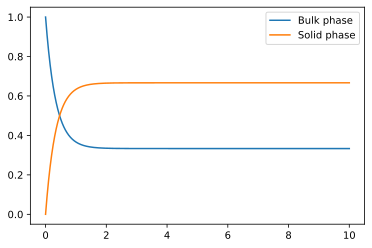

In [4]:
# Run simulation and plot results
run_simulation(linear_model)

# Plot results
plt.figure()
time = linear_model.root.output.solution.solution_times
solution_bulk = linear_model.root.output.solution.unit_000.solution_bulk
solution_solid = linear_model.root.output.solution.unit_000.solution_solid
plt.plot(time, solution_bulk, label='Bulk phase')
plt.plot(time, solution_solid, label='Solid phase')
plt.legend()

## Example 2: Linear adsorption model with linear concentration gradient

To plot the solid phase concentration as a function of the bulk concentration, we can introduce a linear concentration gradient to the `CSTR` that has an initial concentration of $0~mM$.
For this purpose, we will make use of the `flowrate_filter` function of the `CSTR` (see [here](https://cadet.github.io/master/interface/unit_operations/cstr.html)).
This way, we can add mass (or particles) to the tank without increasing it's volume.

In [5]:
linear_gradient_model = get_cadet_template(n_units=2)

n_comp = 2
Q = 1e-3

# INLET
linear_gradient_model.root.input.model.unit_000.unit_type = 'INLET'
linear_gradient_model.root.input.model.unit_000.ncomp = n_comp
linear_gradient_model.root.input.model.unit_000.inlet_type = 'PIECEWISE_CUBIC_POLY'

# CSTR
linear_gradient_model.root.input.model.unit_001.unit_type = 'CSTR'
linear_gradient_model.root.input.model.unit_001.ncomp = n_comp
linear_gradient_model.root.input.model.unit_001.init_volume = 1e-3
linear_gradient_model.root.input.model.unit_001.porosity = 0.5
linear_gradient_model.root.input.model.unit_001.init_c = n_comp*[0]
linear_gradient_model.root.input.model.unit_001.init_q = n_comp*[0]
linear_gradient_model.root.input.model.unit_001.flow_rate_filter = Q

# Sections and Switches
linear_gradient_model.root.input.solver.sections.nsec = 1
linear_gradient_model.root.input.solver.sections.section_times = [0.0, 1]
linear_gradient_model.root.input.solver.user_solution_times = np.linspace(0, 1, 1001)

linear_gradient_model.root.input.model.unit_000.sec_000.const_coeff = n_comp*[0]
linear_gradient_model.root.input.model.unit_000.sec_000.lin_coeff = n_comp*[1]

linear_gradient_model.root.input.model.connections.nswitches = 1
linear_gradient_model.root.input.model.connections.switch_000.section = 0
linear_gradient_model.root.input.model.connections.switch_000.connections = [0, 1, -1, -1, Q]

To later simplify setting up models, we will use a `Dict` to define the model parameters and assign them later in the configuration tree.
Also, for this setup, we assume rapid equilibrium by setting `is_kinetic` to False.

In [6]:
adsorption_model = 'LINEAR'
adsorption_parameters = Dict()
adsorption_parameters.is_kinetic = False
adsorption_parameters.lin_ka = [3, 2]
adsorption_parameters.lin_kd = [1, 1]

linear_gradient_model.root.input.model.unit_001.nbound = n_comp*[1]
linear_gradient_model.root.input.model.unit_001.adsorption_model = adsorption_model
linear_gradient_model.root.input.model.unit_001.adsorption = adsorption_parameters

We now run the simulation and plot the results.

Simulation completed successfully


Text(0, 0.5, '$c_{solid}$')

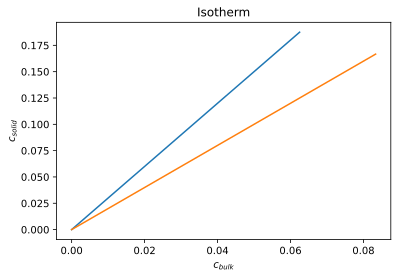

In [7]:
# Run simulation and plot results
run_simulation(linear_gradient_model)

solution_bulk = linear_gradient_model.root.output.solution.unit_001.solution_bulk
solution_solid = linear_gradient_model.root.output.solution.unit_001.solution_solid

plt.figure()
plt.title('Isotherm')
plt.plot(solution_bulk, solution_solid)
plt.xlabel('$c_{bulk}$')
plt.ylabel('$c_{solid}$')

## Example 3: Multi component Langmuir model

Usually, the linear isotherm can only be assumed for very low solute concentrations.
At higher, higher concentrations the limited number of available binding sites on the surface of the adsorbent also needs to be considered which the [Langmuir equation](https://cadet.github.io/master/modelling/binding/multi_component_langmuir.html) takes into account.

$$q = q_{sat} \cdot \frac{b \cdot c}{1 + b \cdot c} = \frac{a \cdot c}{1 + b \cdot c}$$

***with:*** 
> $q_{Sat}$: saturation loading  
> $b$ = equilibrium factor

***Assumptions:***
- All of the adsorption sites are equivalent, and each site can only accommodate one molecule
- The surface is energetically homogeneous
- Adsorbed molecules do not interact
- There are no phase transitions
- At the maximum adsorption, only a monolayer is formed

For this example, we will introduce a concentration step to the `CSTR`. 
We consider two components, both with an inital concentration of $0~mM$, but with different binding strengths.

In [8]:
langmuir_model = get_cadet_template(n_units=2)

# INTLET
langmuir_model.root.input.model.unit_000.unit_type = 'INLET'
langmuir_model.root.input.model.unit_000.ncomp = 2
langmuir_model.root.input.model.unit_000.inlet_type = 'PIECEWISE_CUBIC_POLY'

# CSTR
langmuir_model.root.input.model.unit_001.unit_type = 'CSTR'
langmuir_model.root.input.model.unit_001.ncomp = 2
langmuir_model.root.input.model.unit_001.init_volume = 1e-3
langmuir_model.root.input.model.unit_001.porosity = 0.5
langmuir_model.root.input.model.unit_001.init_c = [0, 0]
langmuir_model.root.input.model.unit_001.init_q = [0, 0]

# OUTLET
langmuir_model.root.input.model.unit_002.unit_type = 'OUTLET'
langmuir_model.root.input.model.unit_002.ncomp = 2

# Sections and Switches
langmuir_model.root.input.solver.sections.nsec = 1
langmuir_model.root.input.solver.sections.section_times = [0.0, 10]
langmuir_model.root.input.solver.user_solution_times = np.linspace(0, 10, 1001)
langmuir_model.root.input.model.unit_000.sec_000.const_coeff = n_comp*[1.0,]


langmuir_model.root.input.model.connections.nswitches = 1
langmuir_model.root.input.model.connections.switch_000.section = 0
langmuir_model.root.input.model.connections.switch_000.connections = [
    0, 1, -1, -1, 1e-3,
    1, 2, -1, -1, 1e-3
]

As can be seen in the [manual](https://cadet.github.io/master/interface/binding/multi_component_langmuir.html), we need to specify four parameters:
- `IS_KINETIC`: Flag for kinetic or quasi-stationary binding
- `MCL_KA`: Adsorption rate
- `MCL_KD`: Desorption rate
- `MCL_QMAX`: Maximum adsorption capacity

In [9]:
langmuir_model.root.input.model.unit_001.nbound = [1, 1]
langmuir_model.root.input.model.unit_001.adsorption_model = 'MULTI_COMPONENT_LANGMUIR'

langmuir_model.root.input.model.unit_001.adsorption.is_kinetic = False
langmuir_model.root.input.model.unit_001.adsorption.mcl_ka = [3, 1]
langmuir_model.root.input.model.unit_001.adsorption.mcl_kd = [1, 1]
langmuir_model.root.input.model.unit_001.adsorption.mcl_qmax = [1, 1]

Then, we run the simulation and plot the concentration of the bulk phase, as well as the solid phase of the `CSTR`.

Simulation completed successfully


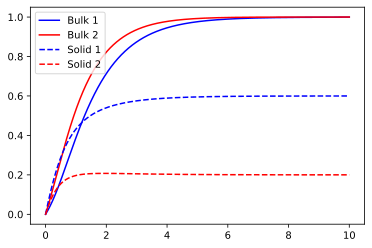

In [10]:
run_simulation(langmuir_model)

time = langmuir_model.root.output.solution.solution_times
solution_bulk = langmuir_model.root.output.solution.unit_001.solution_bulk
solution_solid = langmuir_model.root.output.solution.unit_001.solution_solid


plt.figure()
colors = ['b', 'r']
for c in range(n_comp):
    plt.plot(time, solution_bulk[:,c], '{}'.format(colors[c]), label='Bulk {}'.format(c+1))
for c in range(n_comp):
    plt.plot(time, solution_solid[:,c], '{}--'.format(colors[c]), label='Solid {}'.format(c+1))
plt.legend()